<a href="https://colab.research.google.com/github/hmelberg/causal/blob/master/4%20Difference%20in%20difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Did elimination of copayment increase visits to the physician?

An illustration of the how to apply the difference in difference method in Python

Hans Olav Melberg, University of Oslo

### Introduction

In 2010 Norway eliminated copayment for visiting a physicial for everybody below 16 years old. Before 2010 the thrshold for copayment was 12. This means that those between 12 and 16 now could go to the doctor with no copayment. The question is then: Did the reform increase their number of visits and if so, by how much? In this paper we focus mainly on one method of answering the question: The difference-in-difference method. The intuition is to compare the trend for the group that is affected with a groups that has a common trend before the reform, but who is not affected by the reform.

![J7P3p[1].png](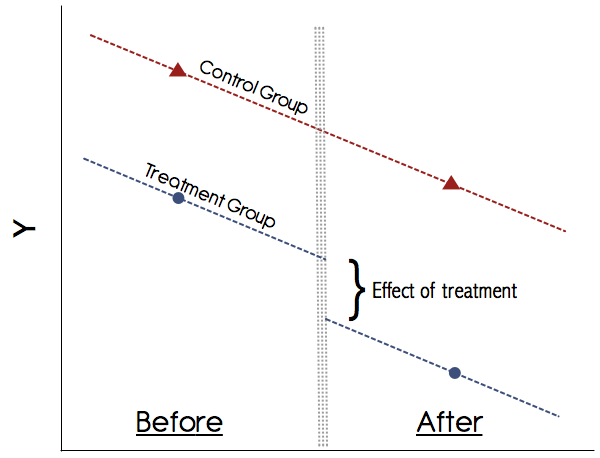)(https://i.stack.imgur.com/J7P3p.png)

In [ ]:
# Import tools
import pandas as pd
import statsmodels.formula.api as smf
import numpy as np

In [ ]:
# read file
file="https://www.dropbox.com/s/5w4l7fvus79wvew/femaleVisitsToPhysician.csv?dl=1"
df=pd.read_csv(file)

In [6]:
# for some reason I liked to work with a variable valled visits instead of consultations
df['visits']=df.consultations
df.head()

,Unnamed: 0,year,age,sex,consultations,population,perCapita,visits
0,4,2006,1,f,67194.0,28221.0,2.380993,67194.0
1,7,2006,2,f,49802.0,28361.0,1.756003,49802.0
2,10,2006,3,f,42741.0,27899.0,1.531990,42741.0
3,13,2006,4,f,36555.0,28420.0,1.286242,36555.0
4,16,2006,5,f,33319.0,29479.0,1.130262,33319.0


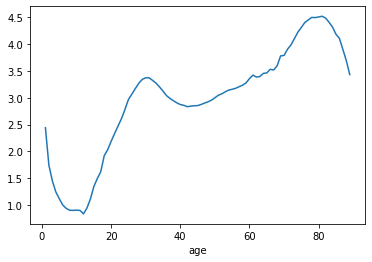

In [7]:
# find average number of visits in different age groups
df.groupby('age')['perCapita'].mean().plot();

In [9]:
# see if there is a time trend for 14 year olds
# create a dataframe with only 14 year olds
df14 = df.query('age==14')
df14

,Unnamed: 0,year,age,sex,consultations,population,perCapita,visits
13,43,2006,14,f,29129.0,30927.0,0.941863,29129.0
102,399,2007,14,f,29563.0,30464.0,0.970424,29563.0
191,752,2008,14,f,29848.0,30578.0,0.976127,29848.0
280,1100,2009,14,f,31140.0,30755.0,1.012518,31140.0
369,1439,2010,14,f,36296.0,30983.0,1.171481,36296.0
458,1774,2011,14,f,39799.0,31522.0,1.262579,39799.0
547,2087,2012,14,f,38880.0,31080.0,1.250965,38880.0
636,2369,2013,14,f,39609.0,30559.0,1.296148,39609.0


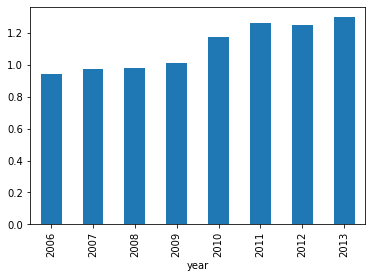

In [10]:
# set year as index to get it on the x-scale
df14.set_index('year').perCapita.plot.bar();

In [11]:
# Now: Want to create a graph that compared the change over time for 14 and 25 year olds
df2 = df.query('age==14 or age==25')

In [12]:
# focus on only those three variables
df2 = df2[['year', 'age', 'perCapita']]

df2.head()

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127


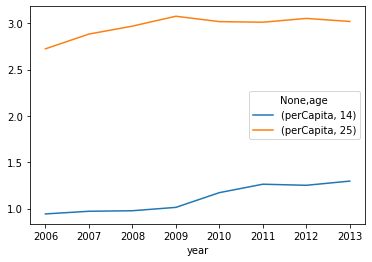

In [14]:
# one way of getting a graph
df2.set_index(['year', 'age']).unstack('age').plot();

In [16]:
# Now: Shape the dataset so we can run a difference-in-difference
# Compare 14 year olds to, for instance, 25 year olds (You should probably use a control group that is closer in age!)

df14and25 = df2.set_index(['year', 'age']).unstack('age')
df14and25

perCapita          
age         14        25
year                    
2006  0.941863  2.724488
2007  0.970424  2.883638
2008  0.976127  2.969386
2009  1.012518  3.076277
2010  1.171481  3.018165
2011  1.262579  3.011706
2012  1.250965  3.052795
2013  1.296148  3.019887

In [18]:
# create a variable that represent the reform (0 before the reform, 1 after)
df14and25['copay'] = 0

In [20]:
df14and25['copay'] = df14and25.copay.where(df14and25.index<2010, 1)

In [22]:
df14and25

perCapita           copay
age         14        25      
year                          
2006  0.941863  2.724488     0
2007  0.970424  2.883638     0
2008  0.976127  2.969386     0
2009  1.012518  3.076277     0
2010  1.171481  3.018165     1
2011  1.262579  3.011706     1
2012  1.250965  3.052795     1
2013  1.296148  3.019887     1

In [24]:
# compare groups means
result = df14and25.groupby('copay').mean()
result

perCapita          
age          14        25
copay                    
0      0.975233  2.913447
1      1.245293  3.025638

In [27]:
result.columns = ['age_14', 'age_25']

In [28]:
result

,age_14,age_25
copay,,
0,0.975233,2.913447
1,1.245293,3.025638


In [29]:
result['age_25'] - result['age_14']

copay
0    1.938214
1    1.780345
dtype: float64

In [30]:
(result['age_25'] - result['age_14']).diff()

copay
0         NaN
1   -0.157869
dtype: float64

In [ ]:
# Now lets run a diff-in-diff regression

In [31]:
df2

,year,age,perCapita
13,2006,14,0.941863
24,2006,25,2.724488
102,2007,14,0.970424
113,2007,25,2.883638
191,2008,14,0.976127
202,2008,25,2.969386
280,2009,14,1.012518
291,2009,25,3.076277
369,2010,14,1.171481
380,2010,25,3.018165


In [32]:
# create new variable
df2['copay']=0
df2['copay']=df2['copay'].where(df2.year<2010,1)
df2

,year,age,perCapita,copay
13,2006,14,0.941863,0
24,2006,25,2.724488,0
102,2007,14,0.970424,0
113,2007,25,2.883638,0
191,2008,14,0.976127,0
202,2008,25,2.969386,0
280,2009,14,1.012518,0
291,2009,25,3.076277,0
369,2010,14,1.171481,1
380,2010,25,3.018165,1


In [33]:
df2['age_14'] = np.where(df2.age==14,1,0)
df2

,year,age,perCapita,copay,age_14
13,2006,14,0.941863,0,1
24,2006,25,2.724488,0,0
102,2007,14,0.970424,0,1
113,2007,25,2.883638,0,0
191,2008,14,0.976127,0,1
202,2008,25,2.969386,0,0
280,2009,14,1.012518,0,1
291,2009,25,3.076277,0,0
369,2010,14,1.171481,1,1
380,2010,25,3.018165,1,0


# difference in difference model (example)

In [37]:
#outcome = treated dummy + after intervention + affected by * after dummy (+ other_variables)

#visits = being_14 + after2010 + being_14 * after2010

model = 'perCapita ~ age_14 + copay + copay * age_14 + year'

In [38]:
mod = smf.ols(formula=model, data=df2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              perCapita   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     987.2
Date:                Mon, 28 Sep 2020   Prob (F-statistic):           5.65e-14
Time:                        21:50:41   Log-Likelihood:                 25.410
No. Observations:                  16   AIC:                            -40.82
Df Residuals:                      11   BIC:                            -36.96
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -85.7891     26.764     -3.205   

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
